In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2000-01-01'
end = '2019-12-31'

# Tickers of assets
assets = ['AIG', 'AKAM', 'AMT', 'APA', 'BA', 'BAX', 'BKNG',
          'BMY', 'CMCSA', 'CNP', 'CPB', 'DE', 'MO', 'MSFT', 'NI',
          'NKTR', 'NTAP', 'PCAR', 'PSA', 'REGN', 'SBAC', 'SEE', 'T',
          'TGT', 'TMO', 'TTWO']

assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%%**********************]  26 of 26 completed


In [4]:
# Calculating returns

#Y = data[assets].pct_change().dropna()
Y = data[assets].copy()
Y = Y.resample('M').last().pct_change().dropna()
print(Y.shape)
display(Y.head())

(239, 26)


AIG      AKAM       AMT      APA        BA       BAX  \
Date                                                                    
2000-02-29 -15.2694%   4.8670%  37.2822%  0.0000% -16.7100% -14.6771%   
2000-03-31  23.8863% -38.4450%   0.2538% 36.5170%   2.3689%  15.0229%   
2000-04-30   0.1713% -38.5154%  -5.6962% -2.6381%   4.9587%   8.5878%   
2000-05-31   2.6662% -32.4905% -20.2685% 25.6129%  -1.2139%   2.1113%   
2000-06-30   4.3864%  77.8792%  12.2896% -3.3385%   7.0400%   5.7331%   

                BKNG       BMY    CMCSA      CNP  ...      NTAP      PCAR  \
Date                                              ...                       
2000-02-29  -3.5560% -13.5849% -7.2464% -8.3353%  ...  88.0448%   4.6443%   
2000-03-31  43.0168%  -0.2184%  3.1250% 14.5896%  ... -12.3179%  16.1103%   
2000-04-30 -20.9375%  -7.8650% -5.4545% 12.9974%  ... -10.6496%  -4.8750%   
2000-05-31 -39.7233%   5.0059% -3.6860%  8.7704%  ... -12.6796% -11.3613%   
2000-06-30  -0.3688%   5.7889%  3.4943%  3.5011%  ...  24.6854%  -5.2239%   

                PSA      REGN     SBAC       SEE         T       TGT      TMO  \
Date                                                                            
2000-02-29 -2.7548% 358.8832% 33.6082% -11.4700% -11.9534% -10.2961% -9.7473%   
2000-03-31 -3.8081% -47.6770%  8.6420%   9.3082%  11.5894%  26.6949% 30.4000%   
2000-04-30  6.5476%  -3.3827% -7.6705%   2.4166%   4.7667% -10.9531% -4.9079%   
2000-05-31 -0.2793% -28.6652% -8.3077%   0.6742%  -0.2853%  -5.6896% -4.1936%   
2000-06-30  6.1300%  46.3190% 39.4295%  -6.4732%   0.7153%  -7.4776% 13.4680%   

                TTWO  
Date                  
2000-02-29   0.0000%  
2000-03-31   6.5327%  
2000-04-30 -27.3585%  
2000-05-31  -5.8442%  
2000-06-30  33.7931%  

[5 rows x 26 columns]

## 2. Estimating Logarithmic Mean Variance Portfolios

### 2.1 Calculating the portfolio that maximizes Risk Adjusted Return.

In [5]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

port.solvers = ['MOSEK']
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w_1 = port.optimization(model=model, rm=rm, obj=obj, kelly=False, rf=rf, l=l, hist=hist)
w_2 = port.optimization(model=model, rm=rm, obj=obj, kelly='approx', rf=rf, l=l, hist=hist)
w_3 = port.optimization(model=model, rm=rm, obj=obj, kelly='exact', rf=rf, l=l, hist=hist)

w = pd.concat([w_1, w_2, w_3], axis=1)
w.columns = ['Arithmetic', 'Log Approx', 'Log Exact']

display(w)

The problem doesn't have a solution with actual input parameters
The problem doesn't have a solution with actual input parameters
The problem doesn't have a solution with actual input parameters


ValueError: All objects passed were None

<AxesSubplot:>

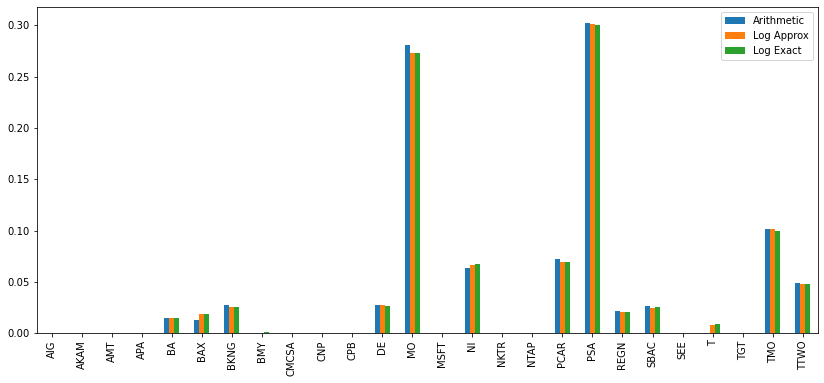

In [4]:
fig, ax = plt.subplots(figsize=(14,6))
w.plot(kind='bar', ax = ax)

In [5]:
returns = port.returns
cov = port.cov

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy()))
x = rp.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Risk Adjusted Return:")
print("Arithmetic", (y/x).item() * 12**0.5)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy()))
x = rp.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Approx", (y/x).item() * 12**0.5)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_3.to_numpy()))
x = rp.Sharpe_Risk(w_3, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Exact", (y/x).item() * 12**0.5)

Risk Adjusted Return:
Arithmetic 1.2708631210924424
Log Approx 1.2712397419739807
Log Exact 1.2712465781050932


### 2.2 Calculate efficient frontier

In [6]:
points = 40 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, kelly="exact", points=points, rf=rf, hist=hist)

display(frontier.T.head())

AIG    AKAM     AMT     APA      BA     BAX    BKNG     BMY   CMCSA  \
0 0.0000% 0.0000% 0.0000% 0.9497% 0.0000% 6.4552% 0.0000% 8.8793% 4.2373%   
1 0.0000% 0.0000% 0.0000% 0.0000% 0.5034% 4.1813% 1.5452% 4.3751% 0.0000%   
2 0.0000% 0.0000% 0.0000% 0.0000% 1.1276% 2.6421% 2.3361% 1.5717% 0.0000%   
3 0.0000% 0.0000% 0.0000% 0.0000% 1.1700% 0.0000% 3.1115% 0.0000% 0.0000%   
4 0.0000% 0.0000% 0.0000% 0.0000% 0.0296% 0.0000% 3.9898% 0.0000% 0.0000%   

      CNP  ...    NTAP    PCAR      PSA    REGN    SBAC     SEE       T  \
0 4.6782%  ... 0.0000% 0.0469% 21.9202% 0.9367% 0.0000% 0.0000% 8.8801%   
1 2.5077%  ... 0.0000% 4.8895% 27.7197% 1.6074% 0.9938% 0.0000% 5.0664%   
2 0.5769%  ... 0.0000% 6.4586% 29.6415% 1.9030% 2.1597% 0.0000% 2.5290%   
3 0.0000%  ... 0.0000% 7.3733% 30.3571% 2.4815% 3.3565% 0.0000% 0.0000%   
4 0.0000%  ... 0.0000% 7.5012% 30.0468% 3.1727% 4.7569% 0.0000% 0.0000%   

      TGT     TMO    TTWO  
0 2.6682% 1.3191% 1.8953%  
1 0.0154% 7.7434% 3.7995%  
2 0.0000% 9.6799% 4.5687%  
3 0.0000% 9.7306% 5.7699%  
4 0.0000% 8.3958% 7.7188%  

[5 rows x 26 columns]

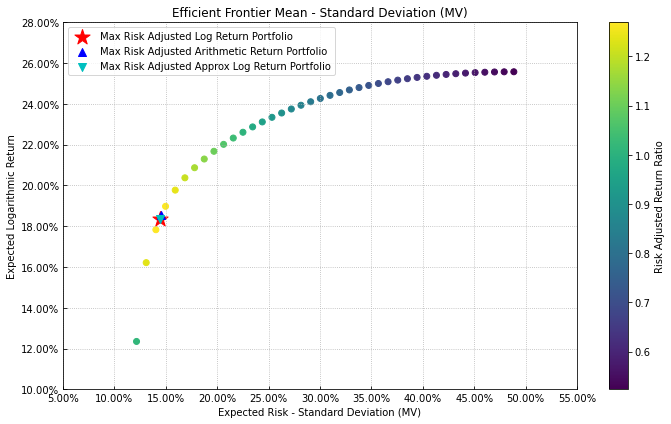

In [7]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Log Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

fig, ax = plt.subplots(figsize=(10,6))
rp.plot_frontier(w_frontier=frontier,
                 mu=mu,
                 cov=cov,
                 returns=returns,
                 rm=rm,
                 kelly=True,
                 rf=rf,
                 alpha=0.05,
                 cmap='viridis',
                 w=w_3,
                 label=label,
                 marker='*',
                 s=16,
                 c='r',
                 height=6,
                 width=10,
                 t_factor=12,
                 ax=ax)

y1 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy())) * 12 
x1 = rp.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05) * 12**0.5

y2 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy())) * 12 
x2 = rp.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05) * 12**0.5

ax.scatter(x=x1,
           y=y1,
           marker="^",
           s=8**2,
           c="b",
           label="Max Risk Adjusted Arithmetic Return Portfolio")
ax.scatter(x=x2,
           y=y2,
           marker="v",
           s=8**2,
           c="c",
           label="Max Risk Adjusted Approx Log Return Portfolio")
plt.legend()

## 2. Estimating Logarithmic Mean EVaR Portfolios

### 2.1 Calculating the portfolio that maximizes Risk Adjusted Return.

In [8]:
rm = 'EVaR' # Risk measure

w_1 = port.optimization(model=model, rm=rm, obj=obj, kelly=False, rf=rf, l=l, hist=hist)
w_2 = port.optimization(model=model, rm=rm, obj=obj, kelly='approx', rf=rf, l=l, hist=hist)
w_3 = port.optimization(model=model, rm=rm, obj=obj, kelly='exact', rf=rf, l=l, hist=hist)

w = pd.concat([w_1, w_2, w_3], axis=1)
w.columns = ['Arithmetic', 'Log Approx', 'Log Exact']

display(w)

Arithmetic  Log Approx  Log Exact
AIG       0.0000%     0.0000%    0.0000%
AKAM      0.0000%     0.0000%    0.0000%
AMT       0.0000%     0.0000%    0.0000%
APA       6.6740%     3.2111%    3.5746%
BA        0.0000%     0.0000%    0.0000%
BAX       6.0638%     2.5271%    2.6328%
BKNG      6.9308%     5.1606%    5.3196%
BMY       4.7594%     6.8591%    6.9081%
CMCSA     0.0000%     0.0000%    0.0000%
CNP       0.0000%     2.3999%    2.2606%
CPB       0.0000%     0.0000%    0.0000%
DE        0.0000%     0.0001%    0.0000%
MO       16.0365%    21.2115%   20.9253%
MSFT      0.0000%     0.0000%    0.0000%
NI        0.0000%     0.0000%    0.0000%
NKTR      6.8735%     7.8037%    7.7487%
NTAP      0.0000%     0.0000%    0.0000%
PCAR      0.0000%     0.0001%    0.0000%
PSA      26.3963%    29.7631%   29.5170%
REGN     13.6260%     4.4503%    5.0530%
SBAC      5.2176%     5.4909%    5.4697%
SEE       0.0000%     0.0000%    0.0000%
T         0.0000%     0.3653%    0.1755%
TGT       0.0000%     0.0000%    0.0000%
TMO       0.0000%     0.0000%    0.0000%
TTWO      7.4222%    10.7570%   10.4152%

<AxesSubplot:>

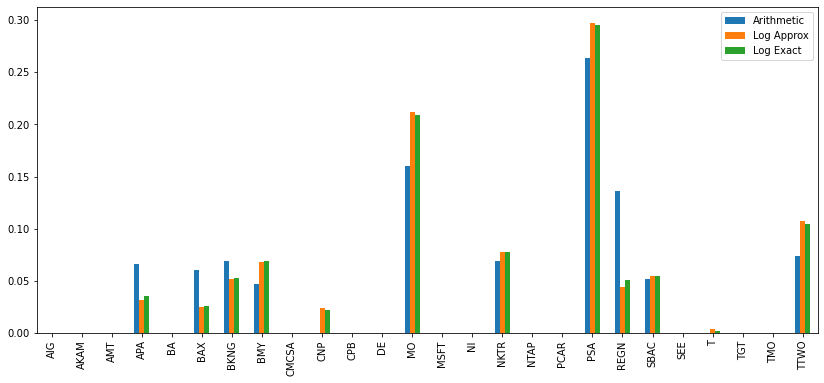

In [9]:
fig, ax = plt.subplots(figsize=(14,6))
w.plot(kind='bar', ax = ax)

In [10]:
returns = port.returns
cov = port.cov

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy()))
x = rp.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Risk Adjusted Return:")
print("Arithmetic", (y/x).item() * 12**0.5)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy()))
x = rp.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Approx", (y/x).item() * 12**0.5)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_3.to_numpy()))
x = rp.Sharpe_Risk(w_3, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Exact", (y/x).item() * 12**0.5)

Risk Adjusted Return:
Arithmetic 0.6328345241128857
Log Approx 0.645853935415245
Log Exact 0.6459339768016784


### 3.2 Calculate efficient frontier

In [11]:
points = 40 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, kelly="exact", points=points, rf=rf, hist=hist)

display(frontier.T.head())

AIG    AKAM     AMT     APA      BA     BAX    BKNG      BMY   CMCSA  \
0 0.0000% 0.0000% 0.0000% 0.0000% 0.0000% 2.8293% 2.3021% 18.2682% 0.0000%   
1 0.0000% 0.0000% 0.0000% 3.4832% 0.0000% 3.9411% 3.1868% 11.6400% 0.0000%   
2 0.0000% 0.0000% 0.0000% 4.3953% 0.0000% 3.0234% 3.8072% 10.2550% 0.0000%   
3 0.0000% 0.0000% 0.0000% 4.0924% 0.0000% 3.0385% 4.7244%  8.0627% 0.0000%   
4 0.0000% 0.0000% 0.0000% 3.2559% 0.0000% 2.4338% 5.5133%  6.3207% 0.0000%   

      CNP  ...    NTAP    PCAR      PSA    REGN    SBAC     SEE       T  \
0 1.9354%  ... 0.0000% 0.0000% 17.2214% 0.0000% 5.2722% 0.0000% 6.7943%   
1 3.6459%  ... 0.0000% 0.0000% 25.2858% 0.0000% 7.1268% 0.0000% 4.4858%   
2 3.3127%  ... 0.0000% 0.0000% 27.4594% 1.2358% 6.6436% 0.0000% 1.9048%   
3 2.6206%  ... 0.0000% 0.0000% 28.5343% 3.7233% 5.8076% 0.0000% 0.9777%   
4 2.1010%  ... 0.0000% 0.0000% 29.9199% 5.5798% 5.3796% 0.0000% 0.0000%   

      TGT     TMO     TTWO  
0 0.0000% 7.5230%  8.0869%  
1 0.0000% 0.0000% 11.6264%  
2 0.0000% 0.0000% 11.3907%  
3 0.0000% 0.0000% 10.7467%  
4 0.0000% 0.0000% 10.3803%  

[5 rows x 26 columns]

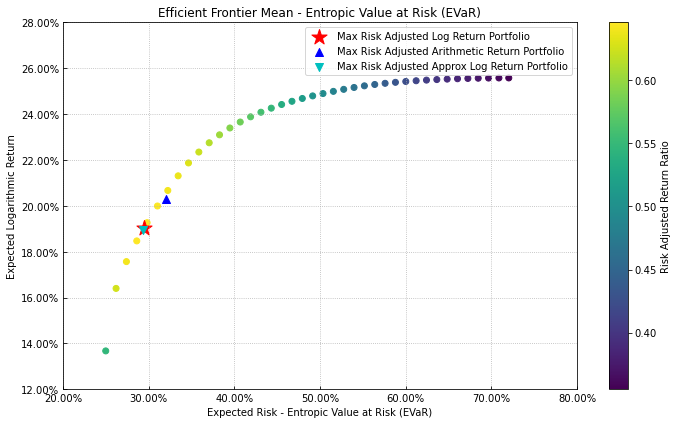

In [12]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Log Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

fig, ax = plt.subplots(figsize=(10,6))
rp.plot_frontier(w_frontier=frontier,
                 mu=mu,
                 cov=cov,
                 returns=returns,
                 rm=rm,
                 kelly=True,
                 rf=rf,
                 alpha=0.05,
                 cmap='viridis',
                 w=w_3,
                 label=label,
                 marker='*',
                 s=16,
                 c='r',
                 height=6,
                 width=10,
                 t_factor=12,
                 ax=ax)

y1 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy())) * 12
x1 = rp.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05) * 12**0.5

y2 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy())) * 12
x2 = rp.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05) * 12**0.5

ax.scatter(x=x1,
           y=y1,
           marker="^",
           s=8**2,
           c="b",
           label="Max Risk Adjusted Arithmetic Return Portfolio")
ax.scatter(x=x2,
           y=y2,
           marker="v",
           s=8**2,
           c="c",
           label="Max Risk Adjusted Approx Log Return Portfolio")
plt.legend()

## 3. Estimating Logarithmic Mean EDaR Portfolios

### 3.1 Calculating the portfolio that maximizes Risk Adjusted Return.

In [13]:
rm = 'EDaR' # Risk measure

w_1 = port.optimization(model=model, rm=rm, obj=obj, kelly=False, rf=rf, l=l, hist=hist)
w_2 = port.optimization(model=model, rm=rm, obj=obj, kelly='approx', rf=rf, l=l, hist=hist)
w_3 = port.optimization(model=model, rm=rm, obj=obj, kelly='exact', rf=rf, l=l, hist=hist)

w = pd.concat([w_1, w_2, w_3], axis=1)
w.columns = ['Arithmetic', 'Log Approx', 'Log Exact']

display(w)

Arithmetic  Log Approx  Log Exact
AIG       0.0000%     0.0000%    0.0000%
AKAM      0.0000%     0.0000%    0.0000%
AMT       2.8670%     0.3727%    0.5224%
APA       0.0000%     0.0000%    0.0000%
BA        0.0000%     0.0000%    0.0000%
BAX       0.0000%     0.0000%    0.0000%
BKNG      3.0492%     1.4551%    1.6956%
BMY       0.0000%     0.0000%    0.0000%
CMCSA     0.0000%     0.0000%    0.0000%
CNP       0.0000%     0.0000%    0.0000%
CPB       0.0000%     0.0000%    0.0000%
DE        0.0000%     0.0000%    0.0000%
MO       27.1690%    34.2848%   33.5919%
MSFT      0.0000%     0.0000%    0.0000%
NI        0.0000%     0.0000%    0.0000%
NKTR     12.5570%     9.2335%   10.2399%
NTAP      0.0000%     0.0000%    0.0000%
PCAR      0.0000%     0.0002%    0.0000%
PSA      25.6707%    33.9465%   30.4418%
REGN     19.7833%    12.5667%   14.1518%
SBAC      0.0000%     3.8721%    3.7937%
SEE       0.0000%     0.0000%    0.0000%
T         0.0000%     0.0000%    0.0000%
TGT       0.0000%     0.0000%    0.0000%
TMO       0.0000%     0.0001%    0.0000%
TTWO      8.9038%     4.2680%    5.5630%

<AxesSubplot:>

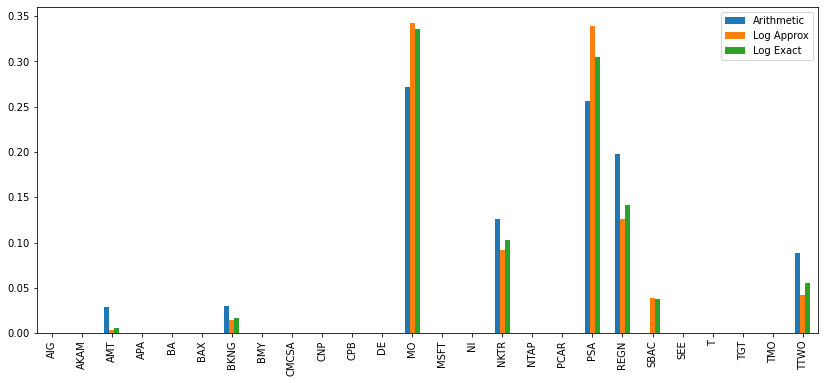

In [14]:
fig, ax = plt.subplots(figsize=(14,6))
w.plot(kind='bar', ax = ax)

In [15]:
returns = port.returns
cov = port.cov

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy()))
x = rp.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Risk Adjusted Return:")
print("Arithmetic", (y/x).item() * 12)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy()))
x = rp.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Approx", (y/x).item() * 12)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_3.to_numpy()))
x = rp.Sharpe_Risk(w_3, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Exact", (y/x).item() * 12)

Risk Adjusted Return:
Arithmetic 0.8286219613071538
Log Approx 0.8435798738462544
Log Exact 0.8449873687053613


### 3.2 Calculate efficient frontier

In [16]:
points = 40 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, kelly="exact", points=points, rf=rf, hist=hist)

display(frontier.T.head())

AIG    AKAM     AMT     APA      BA     BAX    BKNG     BMY   CMCSA  \
0 0.0000% 0.0000% 1.9618% 5.5780% 0.0000% 0.0000% 1.9596% 2.3327% 0.0000%   
1 0.0000% 0.0000% 2.5703% 3.6696% 0.0000% 0.0000% 0.9192% 0.0000% 0.0000%   
2 0.0000% 0.0000% 3.2751% 1.2159% 0.0000% 0.0000% 0.3203% 0.0000% 0.0000%   
3 0.0000% 0.0000% 1.6927% 0.0000% 0.0000% 0.0000% 1.2423% 0.0000% 0.0000%   
4 0.0000% 0.0000% 0.8850% 0.0000% 0.0000% 0.0000% 1.8558% 0.0000% 0.0000%   

      CNP  ...    NTAP    PCAR      PSA     REGN    SBAC     SEE       T  \
0 0.0000%  ... 0.0000% 0.0000% 23.2489%  0.0000% 0.0000% 0.0000% 0.0000%   
1 0.0000%  ... 0.0000% 0.0000% 31.4908%  5.8684% 0.0000% 0.0000% 0.0000%   
2 0.0000%  ... 0.0000% 0.0000% 36.5053%  8.0955% 0.4379% 0.0000% 0.0000%   
3 0.0000%  ... 0.0000% 0.0000% 34.9685% 12.1344% 2.4517% 0.0000% 0.0000%   
4 0.0000%  ... 0.0000% 0.0000% 27.4040% 15.3669% 3.4524% 0.0000% 0.0000%   

      TGT     TMO    TTWO  
0 0.0000% 0.0000% 0.0000%  
1 0.0000% 0.0000% 0.0000%  
2 0.0000% 0.0000% 0.7603%  
3 0.0000% 0.0000% 3.5029%  
4 0.0000% 0.0000% 6.5588%  

[5 rows x 26 columns]

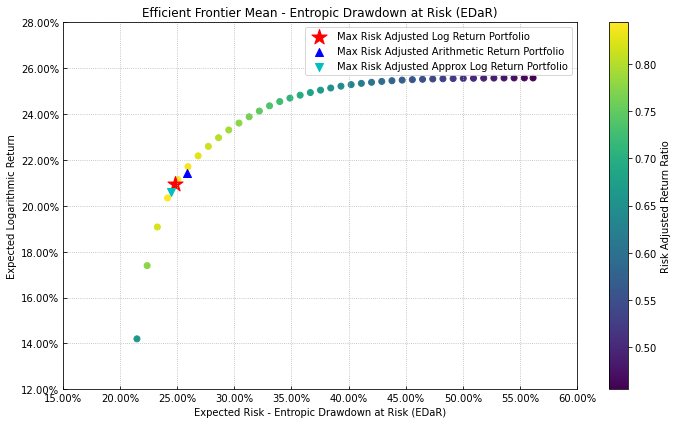

In [17]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Log Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

fig, ax = plt.subplots(figsize=(10,6))
rp.plot_frontier(w_frontier=frontier,
                 mu=mu,
                 cov=cov,
                 returns=returns,
                 rm=rm,
                 kelly=True,
                 rf=rf,
                 alpha=0.05,
                 cmap='viridis',
                 w=w_3,
                 label=label,
                 marker='*',
                 s=16,
                 c='r',
                 height=6,
                 width=10,
                 t_factor=12,
                 ax=ax)

y1 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy())) * 12
x1 = rp.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)

y2 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy())) * 12
x2 = rp.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)

ax.scatter(x=x1,
           y=y1,
           marker="^",
           s=8**2,
           c="b",
           label="Max Risk Adjusted Arithmetic Return Portfolio")
ax.scatter(x=x2,
           y=y2,
           marker="v",
           s=8**2,
           c="c",
           label="Max Risk Adjusted Approx Log Return Portfolio")
plt.legend()